In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import matplotlib
from mne.preprocessing import ICA
import mne
import numpy as np
import pandas as pd
import pyprep
import pyxdf

%run ./../important_files/utils.py

from scipy.signal import welch
import warnings
import json
warnings.filterwarnings("ignore")


## HELPERS ##
def annotate_blinks(
    raw: mne.io.Raw, ch_name: list[str] = ["E25", "E8"]
) -> mne.Annotations:
    """Annotate the blinks in the EEG signal.

    Args:
        raw (mne.io.Raw): The raw EEG data in mne format.
        ch_name (list[str]): The channels to use for the EOG. Default is
                            ["Fp1", "Fp2"]. I would suggest to use the
                            channels that are the most frontal (just above
                            the eyes). In the case of an EGI system the
                            channels would be "E25" and "E8".

    Returns:
        mne.Annotations: The annotations object containing the blink events.
    """
    eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name=ch_name)
    blink_annotations = mne.annotations_from_events(
        eog_epochs.events,
        raw.info["sfreq"],
        event_desc={eog_epochs.events[0, 2]: "blink"},
    )
    return blink_annotations

def annotate_muscle(raw: mne.io.Raw) -> mne.Annotations:
    muscle_annotations, _ = mne.preprocessing.annotate_muscle_zscore(
        raw, 
        threshold=3, # this needs to be calibrated for the entire dataset
        ch_type='eeg', 
        min_length_good=0.1, 
        filter_freq=(95, 120), 
        )

    return muscle_annotations


In [2]:
subject = 'P5197505'

xdf_filename = f'/Users/bryan.gonzalez/CUNY_subs/sub-{subject}/sub-{subject}_ses-S001_task-CUNY_run-001_mobi.xdf'

In [ ]:
df = get_event_data(event='RestingState', 
                        df=import_eeg_data(xdf_filename),
                        stim_df=import_stim_data(xdf_filename))

ch_names = [f"E{i+1}" for i in range(df.shape[1] - 1)]
info = mne.create_info(ch_names, 
                    sfreq=1/df.lsl_time_stamp.diff().mean(), 
                    ch_types='eeg')

TS = df.lsl_time_stamp.values
df.drop(columns=['lsl_time_stamp'], inplace=True)

raw = mne.io.RawArray(df.T * 1e-6, info=info) # multiplying by 1e-6 converts to volts

# Create a Cz reference
value = np.zeros((1, raw.n_times))
info = mne.create_info(["Cz"], raw.info['sfreq'], ch_types='eeg')
cz = mne.io.RawArray(value, info)
raw.add_channels([cz], force_update_info=True)

# Apply a montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
raw.set_montage(montage, on_missing='ignore')

#raw.crop(tmin=0, tmax=5)

prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": np.arange(60, raw.info["sfreq"] / 2, 60),
    }
# these params set up the robust reference  - i.e. median of all channels and interpolate bad channels
prep = pyprep.PrepPipeline(raw, montage=montage, channel_wise=True, prep_params=prep_params)
prep_output = prep.fit()
raw_cleaned = prep_output.raw_eeg

# Save

In [ ]:
 # check if cleaned file already exists
save_path = '/'.join(xdf_filename.split('/')[:-1]) + f'/sub-{subject}_ses-S001_task-CUNY_run-001_eeg_clean.fif'
raw_cleaned.save(save_path, overwrite=True)
 

# Load

In [3]:
raw_cleaned = mne.io.read_raw_fif('/'.join(xdf_filename.split('/')[:-1]) + f'/sub-{subject}_ses-S001_task-CUNY_run-001_eeg_clean.fif', preload=True)


Opening raw data file /Users/bryan.gonzalez/CUNY_subs/sub-P5197505/sub-P5197505_ses-S001_task-CUNY_run-001_eeg_clean.fif...
    Range : 0 ... 299988 =      0.000 ...   299.998 secs
Ready.
Reading 0 ... 299988  =      0.000 ...   299.998 secs...


In [4]:



blink_annotations = annotate_blinks(raw_cleaned, ch_name=["E25", "E8"])

muscle_annotations = annotate_muscle(raw_cleaned)

all_annotations = blink_annotations + muscle_annotations + raw_cleaned.annotations
raw_cleaned.set_annotations(all_annotations)

# Create a binary array
binary_mask = np.zeros(len(raw_cleaned.times), dtype=int)

# Iterate over annotations
for annot in raw_cleaned.annotations:
    onset_sample = int(annot['onset'] * raw_cleaned.info['sfreq'])
    duration_sample = int(annot['duration'] * raw_cleaned.info['sfreq'])
    binary_mask[onset_sample:onset_sample + duration_sample] = 1

percent_good = 1 - np.sum(binary_mask) / len(binary_mask)
print(f'Percent Good Data: {percent_good * 100:.2f}%')
vars['percent_good'] = percent_good * 100

Using EOG channels: E25, E8
EOG channel index for this subject is: [24  7]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel E25 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 83 significant peaks
Number of EOG events detected: 83
Not setting metadata
83 matching events found
No baseline correction applied
Using data from preloaded Raw for 83 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 95 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 95.00
- Lower transition bandwidth: 23.75 Hz (-6 dB cutoff frequency: 83.12 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 139 samples (0.139 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.9s finished


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)

Percent Good Data: 95.57%


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


TypeError: 'builtin_function_or_method' object does not support item assignment

In [ ]:
TS

# Artifact remove with ICA

In [5]:
# set notch filter
raw_cleaned.notch_filter(60)
# set bandpass filter
raw_cleaned.filter(l_freq=1.0, h_freq=50.0) # only keeping frequencies between 1-50 Hz
# play around with this number to get components 
# that seem to represent the actual brain activations well
num_components = .95 
ica = ICA(n_components=num_components, method='picard')
ica.fit(raw_cleaned, reject_by_annotation=True)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Fitting ICA to data using 129 channels (please be patient, this may take a while)
Omitting 13304 of 299989 (4.43%) samples, retaining 286685 (95.57%) samples.


[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    0.6s finished


Selecting by explained variance: 17 components
Fitting ICA took 25.8s.


<ICA | raw data decomposition, method: picard (fit in 71 iterations on 286685 samples), 17 ICA components (129 PCA components available), channel types: eeg, no sources marked for exclusion>

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
99 matching events found
No baseline correction applied
0 projection i

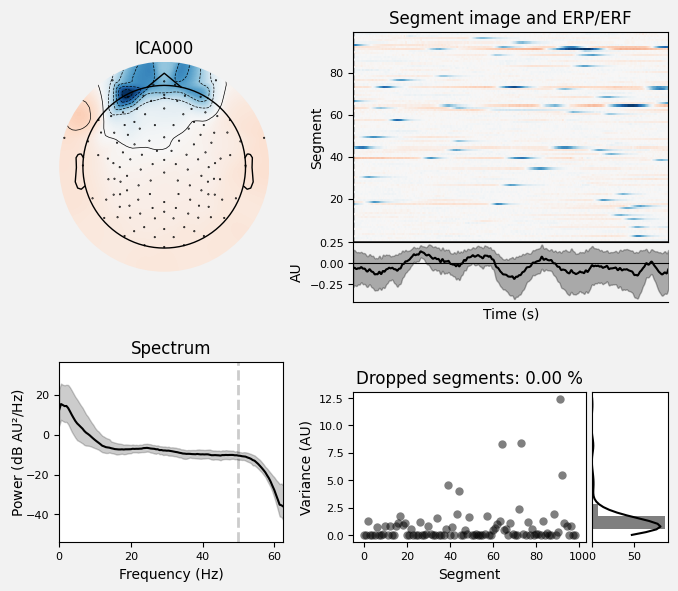

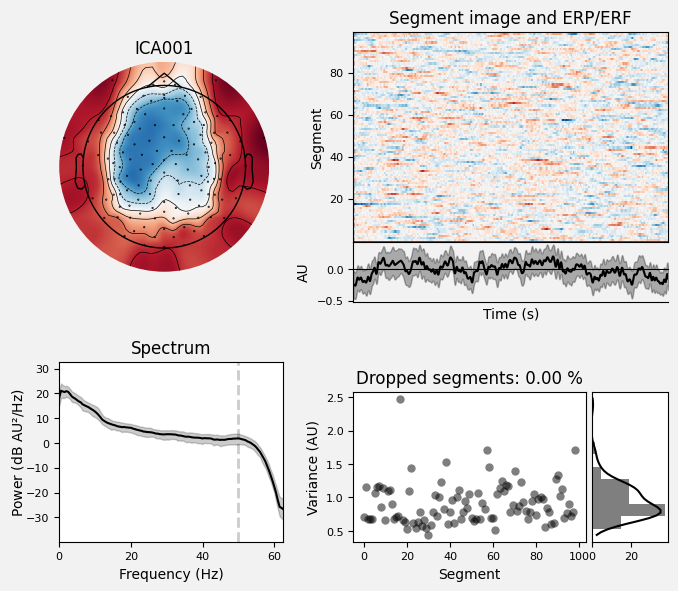

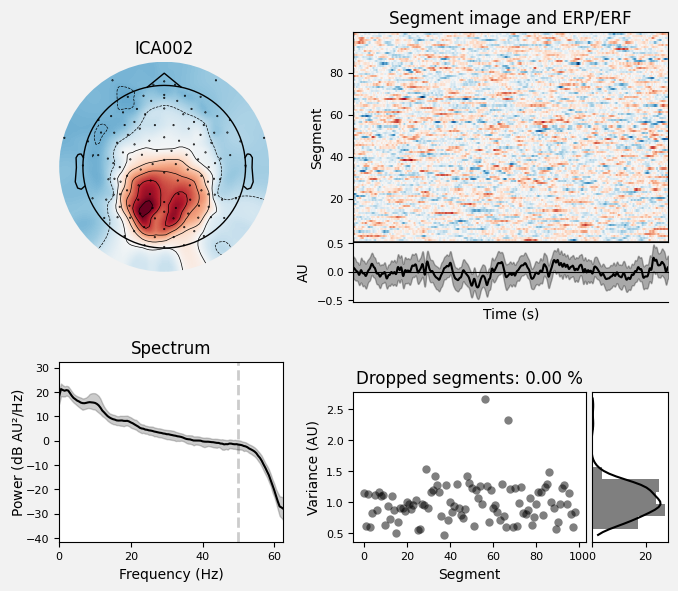

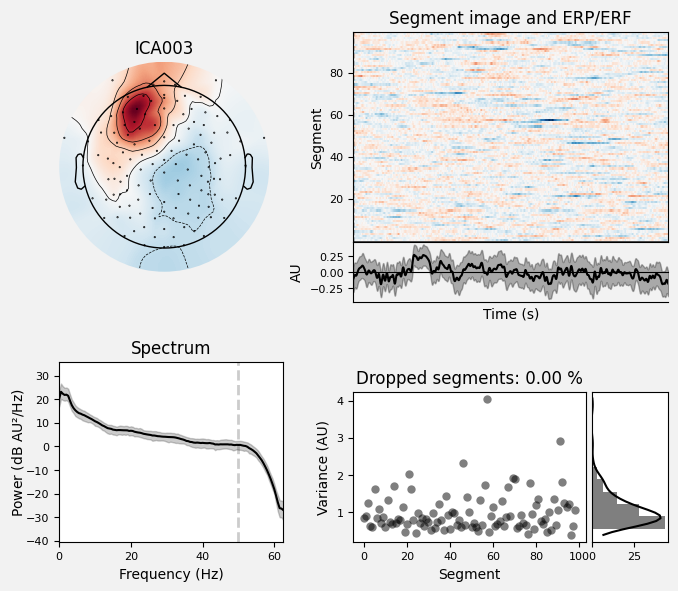

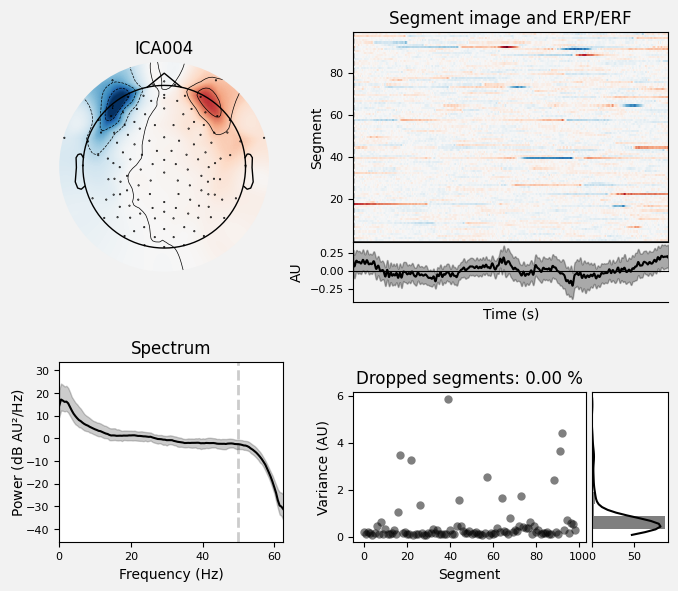

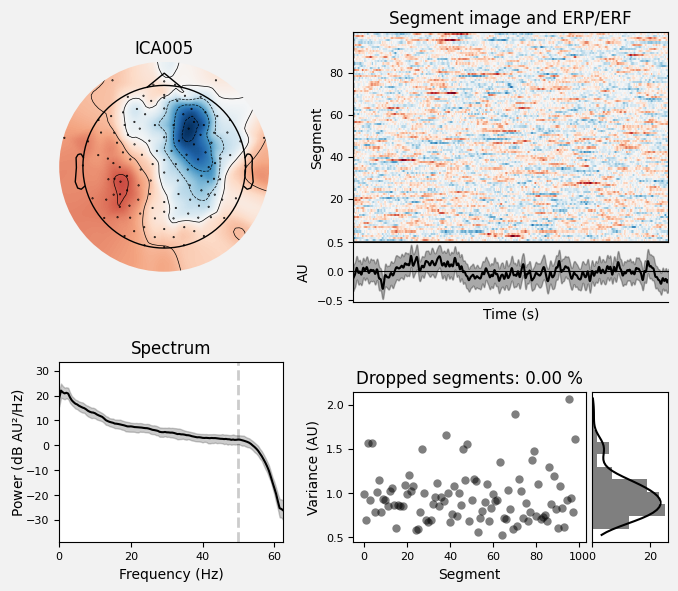

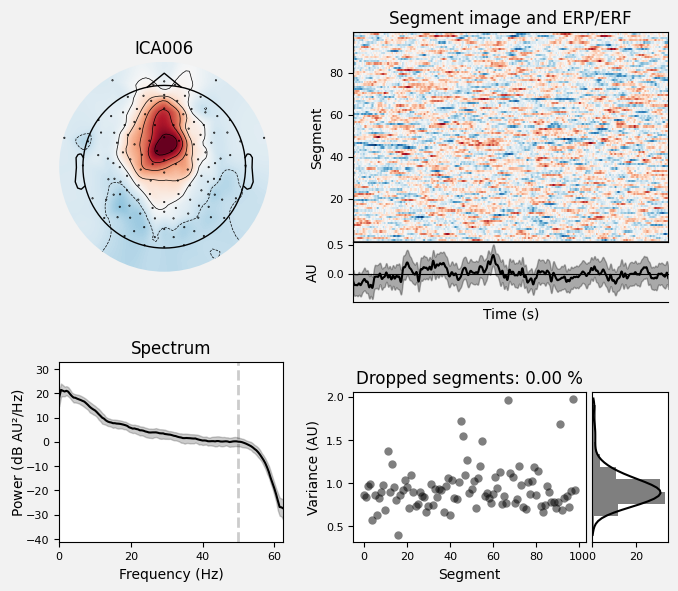

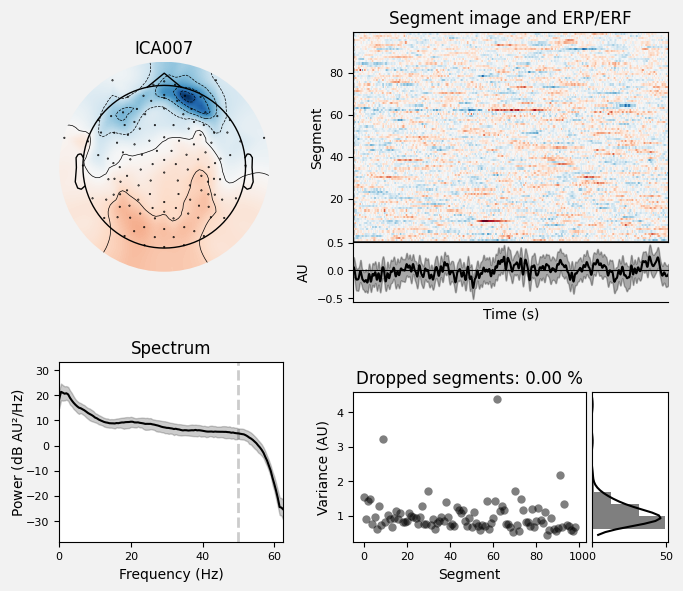

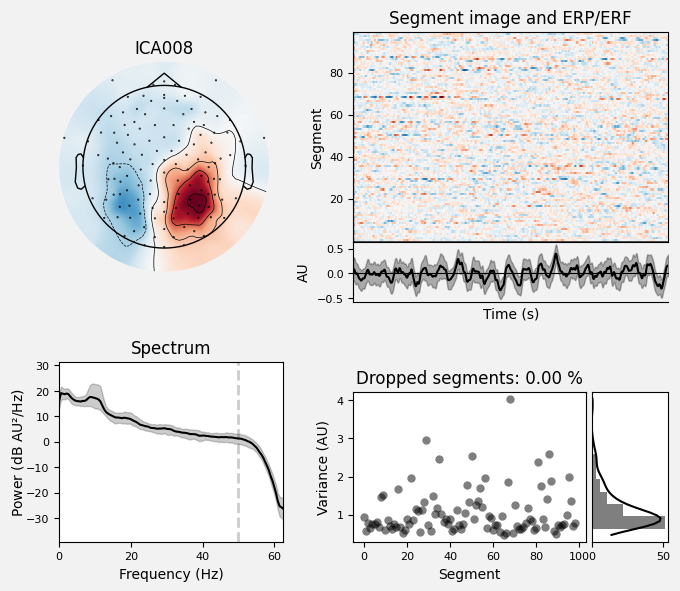

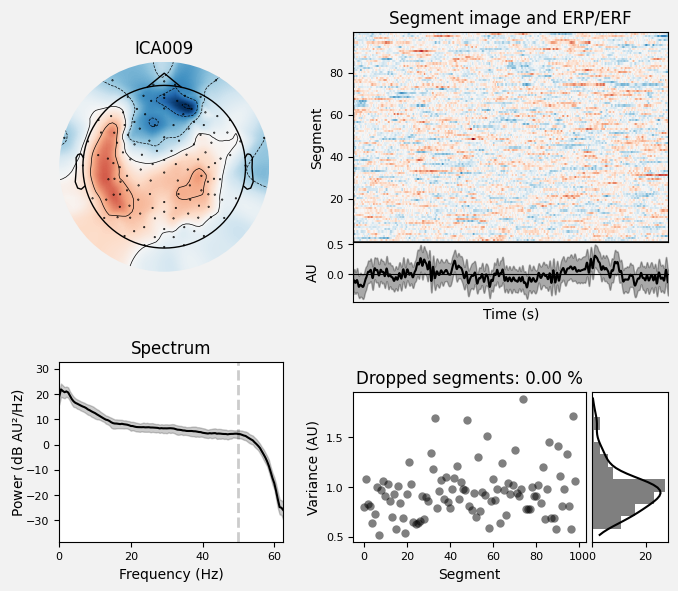

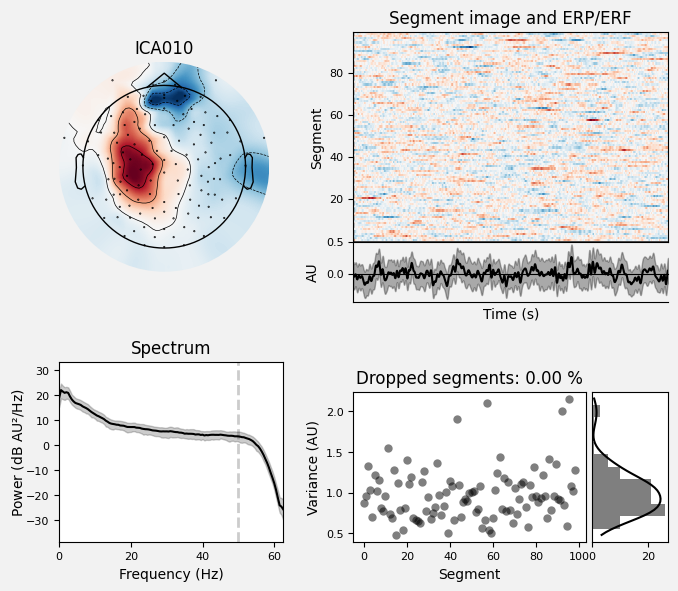

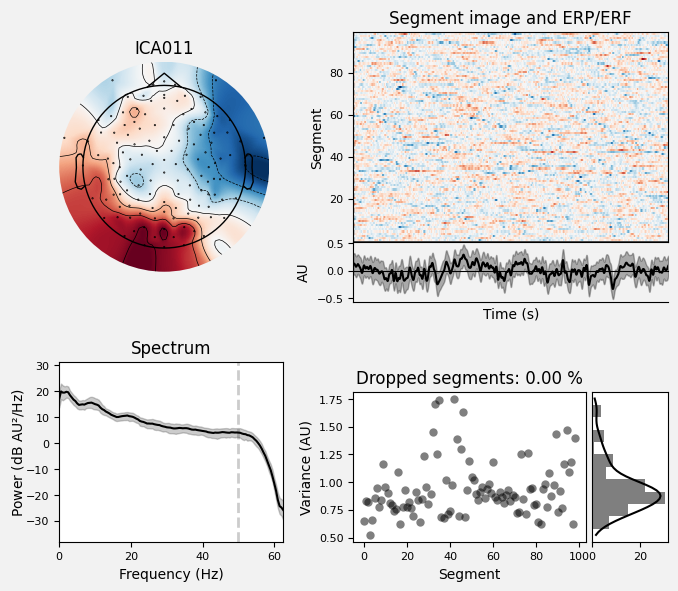

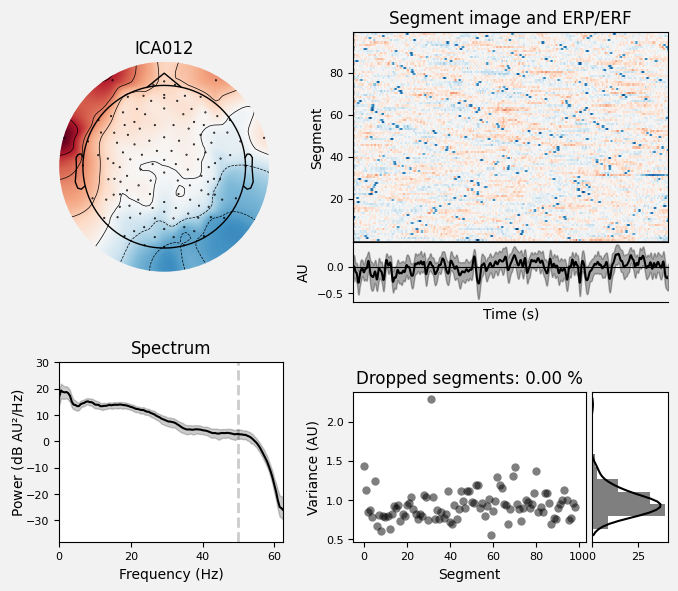

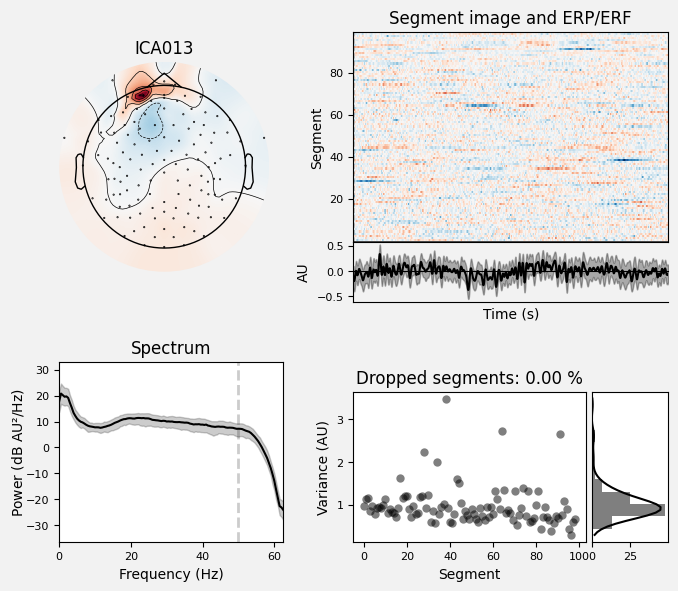

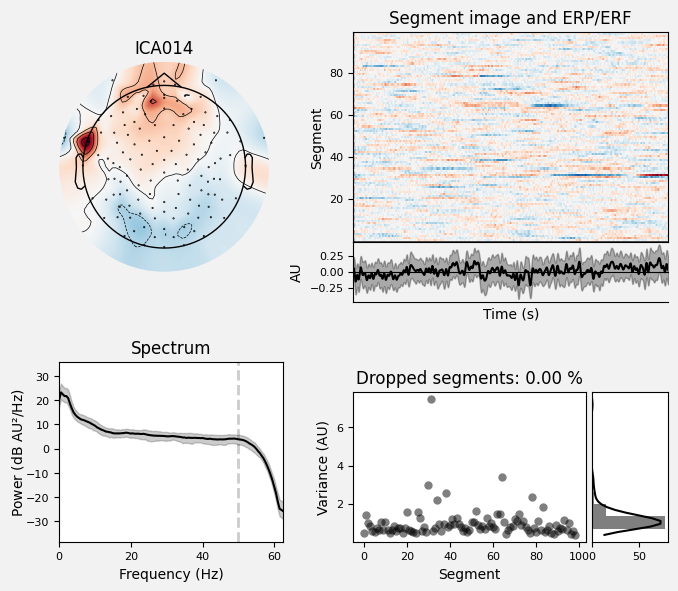

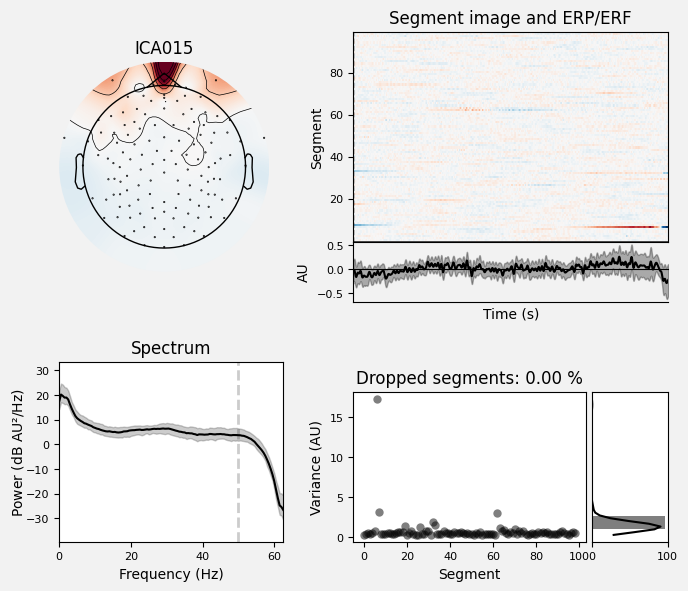

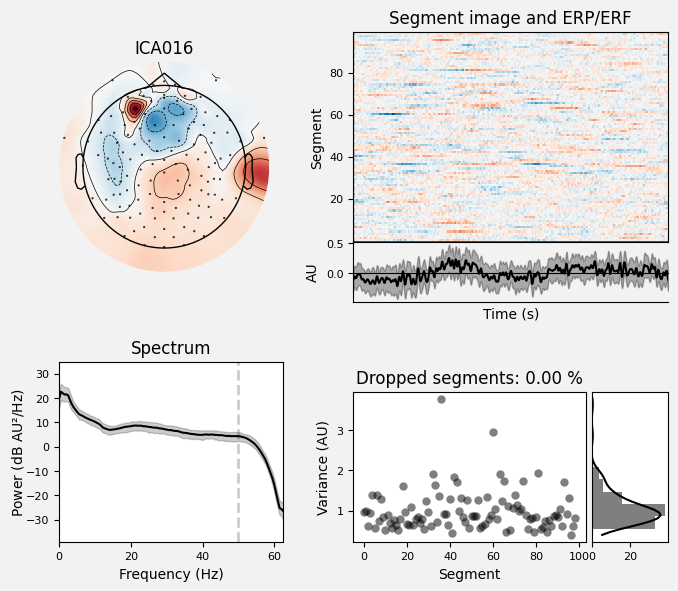

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [6]:
ica.plot_properties(raw_cleaned, picks=range(ica.n_components_)) # This exact component number probably won't work if you recompute ICA

In [7]:
# MNE ICA LABEL
from mne_icalabel import label_components


ic_labels = label_components(raw_cleaned, ica, method='iclabel')
# exclude components that are not brain activity
exclude_components = [i for i, label in enumerate(ic_labels['labels']) if 
                      label not in ['brain', 'other']]

Using matplotlib as 2D backend.


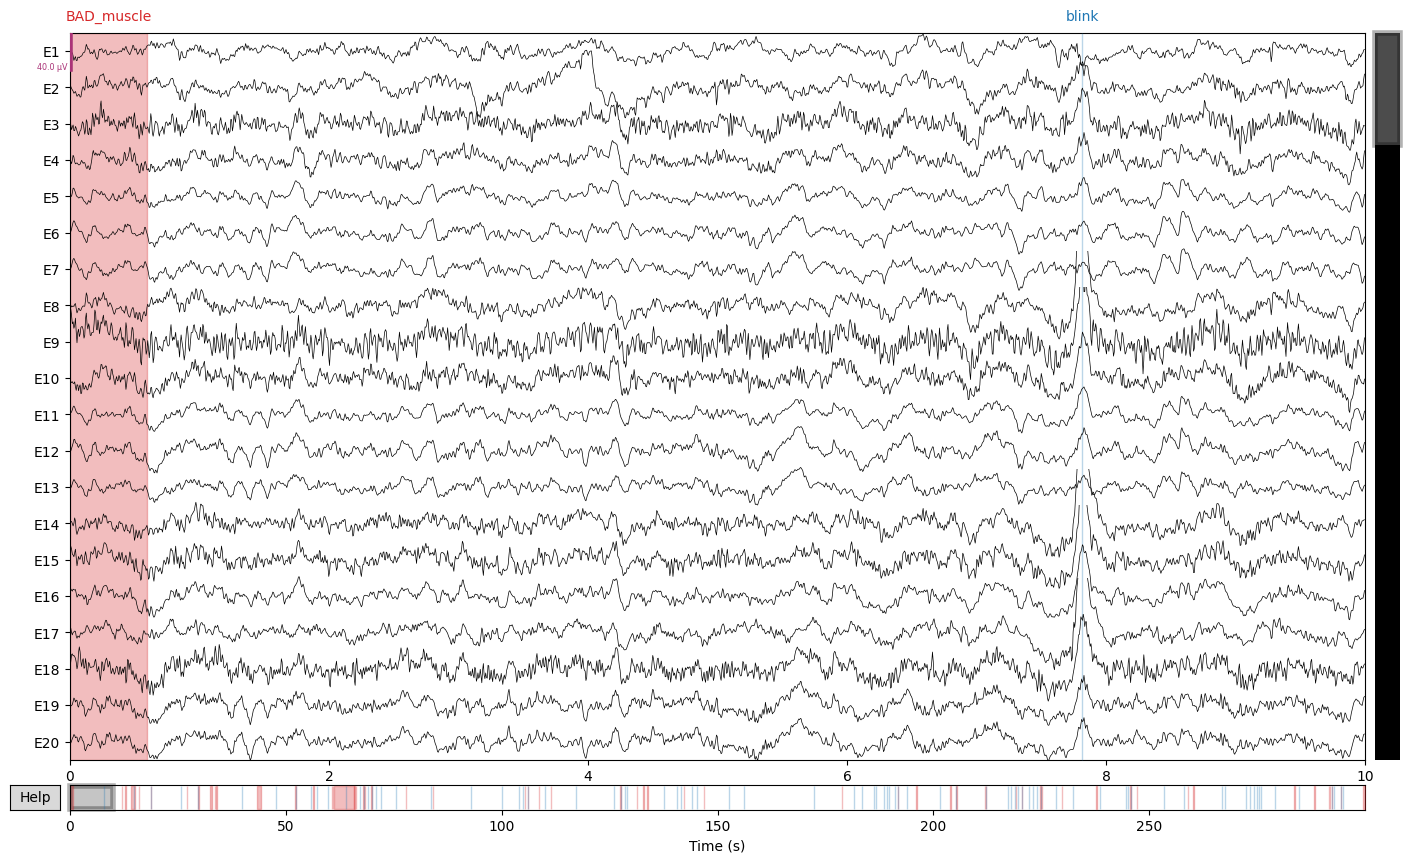

In [8]:
matplotlib.use('Qt5Agg') # or 'TkAgg'

raw_cleaned.plot()

In [11]:
ica.exclude = exclude_components
ica.apply(raw_cleaned)

Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 4 ICA components
    Projecting back using 129 PCA components


<Raw | sub-P5197505_ses-S001_task-CUNY_run-001_eeg_clean.fif, 129 x 299989 (300.0 s), ~295.4 MiB, data loaded>

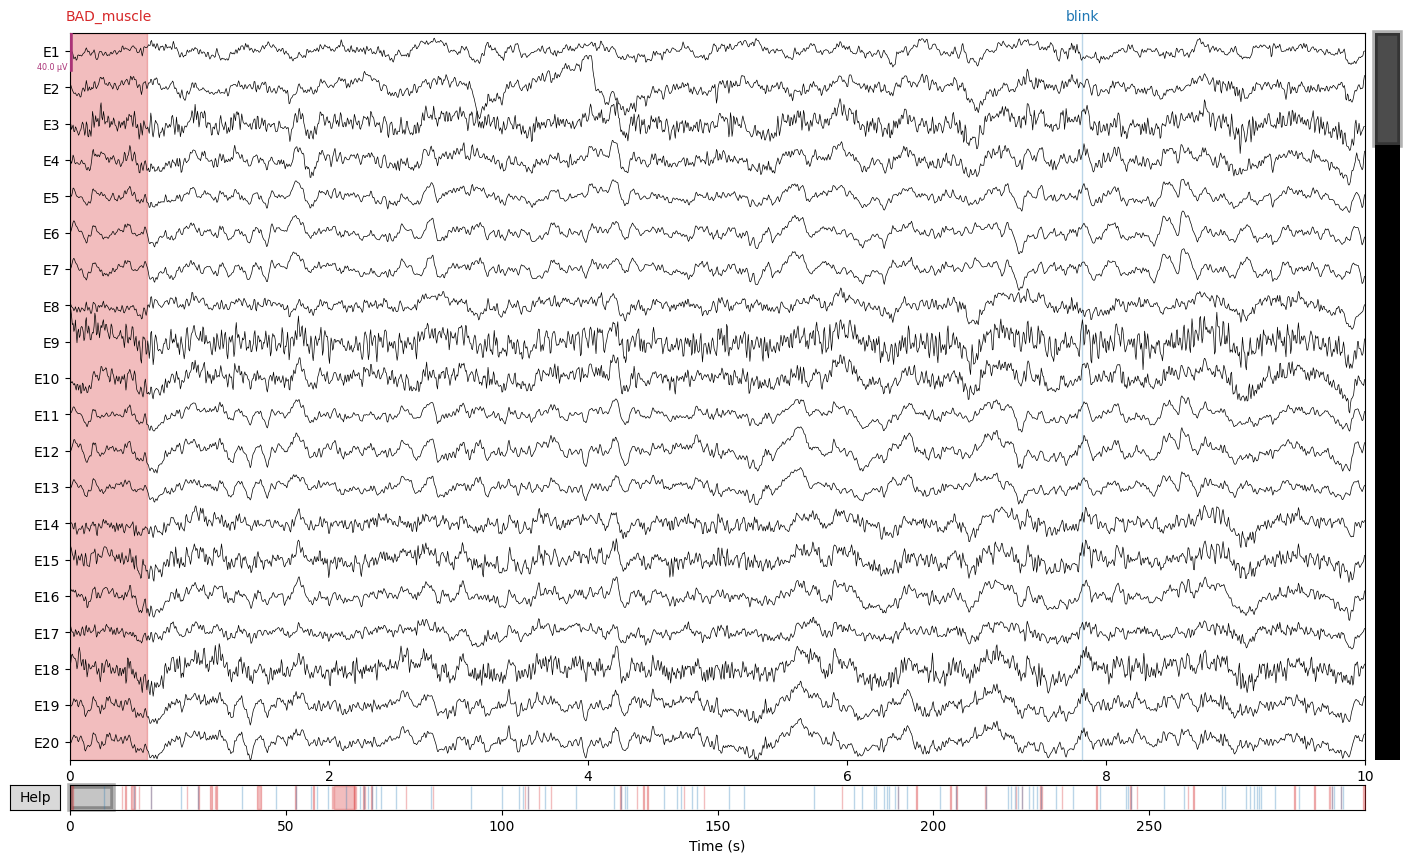

In [12]:
raw_cleaned.plot()

In [ ]:
# plot the components and wait for user input to select components
ica.plot_components( title='ICA Components')
#print("Select components to exclude (e.g., 0, 1, 2) and press Enter:")
#exclude = input().split(',')
#exclude = [int(i.strip()) for i in exclude if i.strip().isdigit()]

In [ ]:
ica.plot_sources(raw_cleaned)

In [ ]:
ica.plot_properties(raw_cleaned, picks=[0,4,13]) # This exact component number probably won't work if you recompute ICA


In [ ]:
ica.plot_overlay(raw_cleaned, exclude=[0,1, 4,11, 13]) # see what the data would look like if we removed the component



In [ ]:
ica.exclude = [0,4,11, 13] # these are the components that we want to exclude
ica.apply(raw_cleaned)

In [ ]:
raw_cleaned.annotations.delete([i for i, desc in enumerate(raw_cleaned.annotations.description) if desc == 'blink' or desc == 'BAD_muscle'])
fig = raw_cleaned.plot(show_scrollbars=False,
                        show_scalebars=False,events=None, start=0, 
                        duration=200,n_channels=50, scalings=.35e-4, color='k', title='EEG Data after ICA')

fig.savefig(f'./report_images/{subject}_cleaned_eeg.png', dpi=300, bbox_inches='tight')

In [ ]:
fig = raw_cleaned.plot_psd(fmax=50, average=False, show=True)
fig.savefig(f'./report_images/{subject}_cleaned_eeg_psd.png', dpi=300, bbox_inches='tight')

In [ ]:
raw_cleaned.plot()

In [ ]:
save_path = '/'.join(xdf_filename.split('/')[:-1]) + f'/sub-{subject}_ses-S001_task-CUNY_run-001_eeg_clean.fif'
raw_cleaned.save(save_path, overwrite=True)